# Observational Data Collection
Grab AIA and HMI observations of the solar disk from the day of the "Great American Eclipse"

In [2]:
import os
import glob

import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.colors
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.time import TimeRange
from sunpy.map import Map
from astropy.coordinates import SkyCoord
import yt
import solarbextrapolation

import synthesizAR

%matplotlib inline

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Downloading the data

Create a query for AIA for the day of 21 August at approximately 18:15 UTC (roughly when the Sun was most eclipsed over Houston).

In [ ]:
result_aia = Fido.search(
    a.Time(TimeRange('2017/08/20 18:15',15*u.s)),
    a.Instrument('AIA'),
    a.Wavelength(94*u.angstrom,335*u.angstrom)
)

In [ ]:
result_aia

In [ ]:
aia_files = Fido.fetch(result_aia)

And download the HMI results as well.

In [ ]:
result_hmi = Fido.search(
    a.Time(TimeRange('2017/08/20 18:15',1*u.min)),
    a.Instrument('HMI') & a.vso.Physobs('LOS_magnetic_field'),
    #a.Wavelength(94*u.angstrom,335*u.angstrom)
)

In [ ]:
result_hmi

In [ ]:
hmi_files = Fido.fetch(result_hmi)

Or if the files have already been downloaded, just grab a list of them

In [3]:
aia_files = glob.glob('/Users/willbarnes/sunpy/data/aia*2017_08_20*.fits')
hmi_files = glob.glob('/Users/willbarnes/sunpy/data/hmi*2017_08_20*.fits')

## Quick Visualizations

In [4]:
aia_files = sorted(aia_files,key=lambda x:int(os.path.basename(x).split('_')[2][:-1]))

In [5]:
aia_files_filtered = aia_files[:5] + [aia_files[-2]]

In [6]:
lc = (-300*u.arcsec,-200*u.arcsec)
rc = (350*u.arcsec,350*u.arcsec)

In [ ]:
fig = plt.figure(figsize=(15,10))
for i,af in enumerate(aia_files_filtered):
    m = Map(af)
    bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
    top_right = SkyCoord(*rc,frame=m.coordinate_frame)
    m = m.submap(bottom_left,top_right)
    ax = fig.add_subplot(2,3,i+1,projection=m)
    m.plot(axes=ax,annotate=False,title=False)

In [ ]:
m = Map(hmi_files[0])
m = m.rotate()

In [ ]:
bottom_left = SkyCoord(*lc,frame=m.coordinate_frame)
top_right = SkyCoord(*rc,frame=m.coordinate_frame)

In [ ]:
plt.figure(figsize=(10,10))
m = m.submap(bottom_left,top_right)
m.plot()

## Extrapolate Field
Now, extrapolate a 3D field from the underlying magnetogram and trace some streamlines through it.

In [7]:
field = synthesizAR.Skeleton(hmi_fits_file=hmi_files[0],crop=(lc,rc),resample=u.Quantity([100,100],u.pixel))

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:128: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


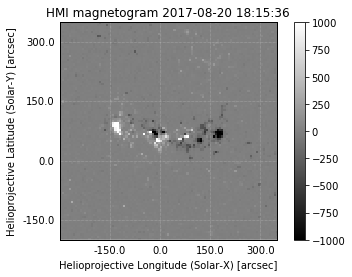

In [8]:
field.hmi_map.peek(vmin=-1000,vmax=1000)

In [9]:
zshape = 100
zrange = u.Quantity([0,max(u.Quantity(rc)-u.Quantity(lc)).value],u.arcsec)

In [10]:
field.extrapolate_field(zshape,zrange)

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev151-py3.5.egg/solarbextrapolation/extrapolators/base.py:82: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev151-py3.5.egg/solarbextrapolation/extrapolators/base.py:83: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.yrange = self.map_boundary_data.yrange.to(map_magnetogram.meta['cunit2'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/solarbextrapolation-0.1.dev151-py3.5.egg/solarbextrapolation/extrapolators/base.py:84: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  self.xobsrange = self.map_boundary_data.xrange.to(map_magnetogram.meta['cunit1'])
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/

True


/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev469-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev469-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev469-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self.clipped_hmi_map.xrange).value,
/Users/willbarnes/anaconda/envs/synthesizar/lib/p

In [11]:
field.extract_streamlines(500,
                          loop_length_range=[1e9,1e11]*u.cm, 
                          close_threshold=0.05,
                          mask_threshold=0.1,
                          safety=5
                         )

/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev469-py3.5.egg/synthesizAR/util/util.py:69: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_x = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.xrange)
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev469-py3.5.egg/synthesizAR/util/util.py:70: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  length_y = convert_angle_to_length(boundary_map_resampled, boundary_map_resampled.yrange)
yt : [INFO     ] 2017-10-27 20:34:20,482 AMRKDTree rebuilt, Final Volume: 8.177348e+31
Streamlining: 100%|██████████| 500/500 [00:00<00:00, 706.16it/s]
yt : [INFO     ] 2017-10-27 20:34:22,147 AMRKDTree rebuilt, Final Volume: 8.177348e+31
Streamlining: 100%|██████████| 90/90 [00:00<00:00, 551.11it/s]
yt : [INFO     ] 2017-10-27 20:34:22,888 AMRKDTree rebuilt, Final Volume: 8.177348e+31
Streamlining:

yt : [INFO     ] 2017-10-27 20:34:25,995 xlim = 949280087.800446 46514724302.221939
yt : [INFO     ] 2017-10-27 20:34:25,995 ylim = -20715662697.752075 25331463285.210602
yt : [INFO     ] 2017-10-27 20:34:25,997 xlim = 949280087.800446 46514724302.221939
yt : [INFO     ] 2017-10-27 20:34:25,998 ylim = -20715662697.752075 25331463285.210602
yt : [INFO     ] 2017-10-27 20:34:26,028 Making a fixed resolution buffer of (('stream', 'By')) 800 by 800
yt : [WARNING  ] 2017-10-27 20:34:26,068 Plot image for field ('stream', 'By') has both positive and negative values. Min = -0.098820, Max = 0.037760.
yt : [WARNING  ] 2017-10-27 20:34:26,069 Switching to symlog colorbar scaling unless linear scaling is specified later



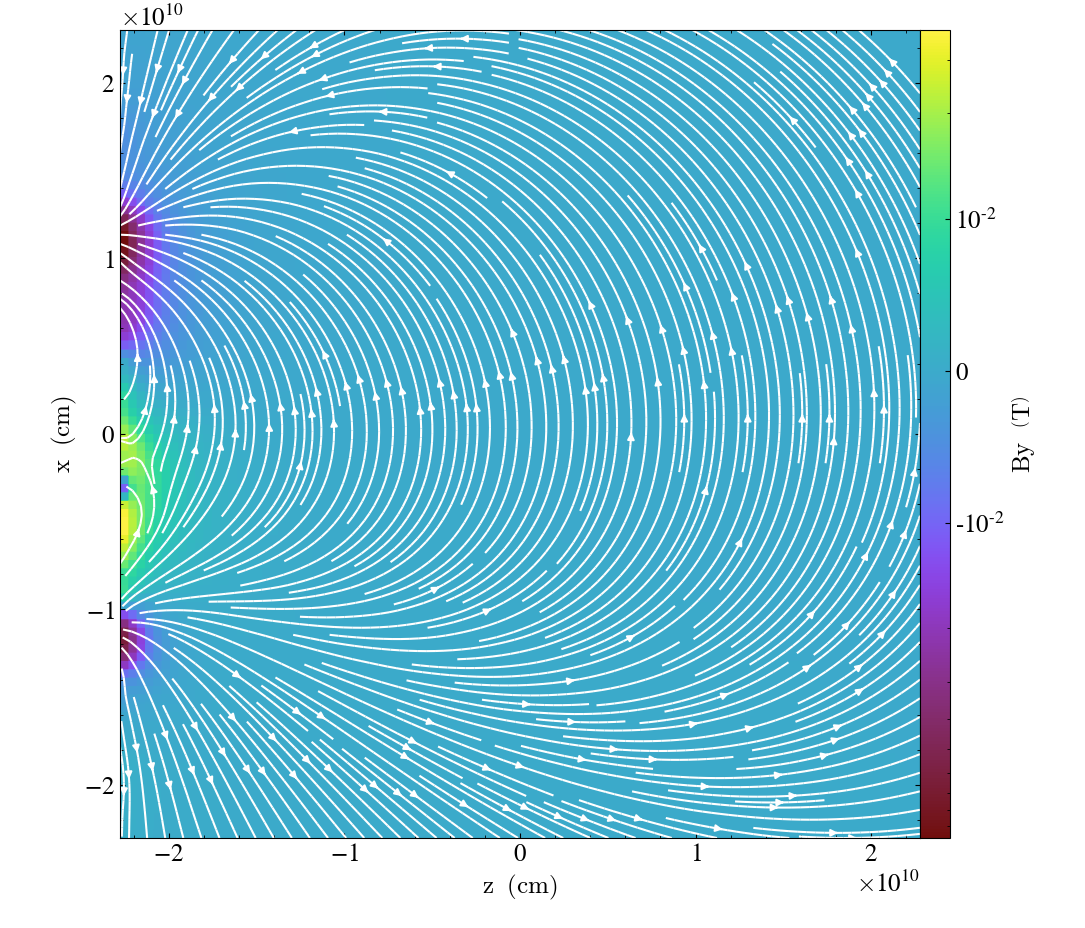

In [12]:
center = (field.extrapolated_3d_field.domain_center 
         + np.array([0,0,0])*field.extrapolated_3d_field.domain_width)
p = yt.SlicePlot(field.extrapolated_3d_field,'y','By',origin='center-domain',axes_unit='cm',
                 center=center)
p.annotate_streamlines('Bz','Bx',density=3,factor=5,plot_args={'color':'w'})

In [42]:
sc = yt.create_scene(field.extrapolated_3d_field,field='Bz')
#sc.camera.zoom(1.5)
cam = sc.add_camera(field.extrapolated_3d_field, lens_type='perspective')
#cam.position = field.extrapolated_3d_field.arr([0.05, 0.5, 0.5], 'code_length')
normal_vector = [1., 0., 0.]
north_vector = [0., 0., 1.]
#cam.switch_orientation(
    #normal_vector=normal_vector,
    #north_vector=north_vector
#                      )
#cam.set_width(field.extrapolated_3d_field.domain_width * 0.5)

yt : [INFO     ] 2017-10-26 23:51:20,422 Rendering scene (Can take a while).
yt : [INFO     ] 2017-10-26 23:51:20,428 Creating volume
/Users/willbarnes/anaconda/envs/synthesizar/lib/python3.5/site-packages/yt/utilities/amr_kdtree/amr_kdtree.py:311: RuntimeWarning: invalid value encountered in log10
  dds.append(np.log10(vcd[field].astype('float64')))
yt : [INFO     ] 2017-10-26 23:51:20,504 Creating transfer function
yt : [INFO     ] 2017-10-26 23:51:20,504 Calculating data bounds. This may take a while.  Set the TranferFunctionHelper.bounds to avoid this.


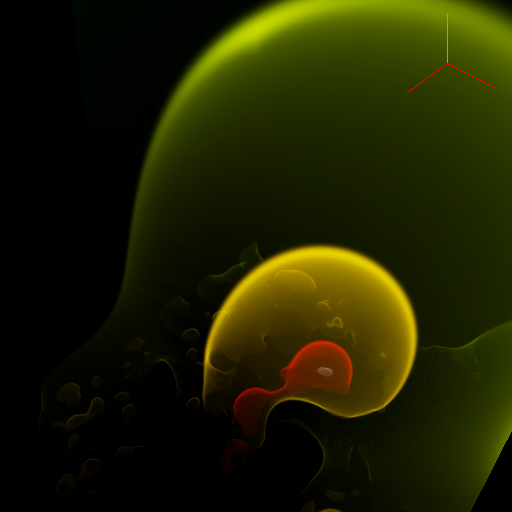

In [43]:
sc.annotate_axes()
sc.show()

In [10]:
field.extrapolated_3d_field.domain_width

YTArray([  4.60471260e+10,   3.89739445e+10,   4.55654442e+10]) code_length

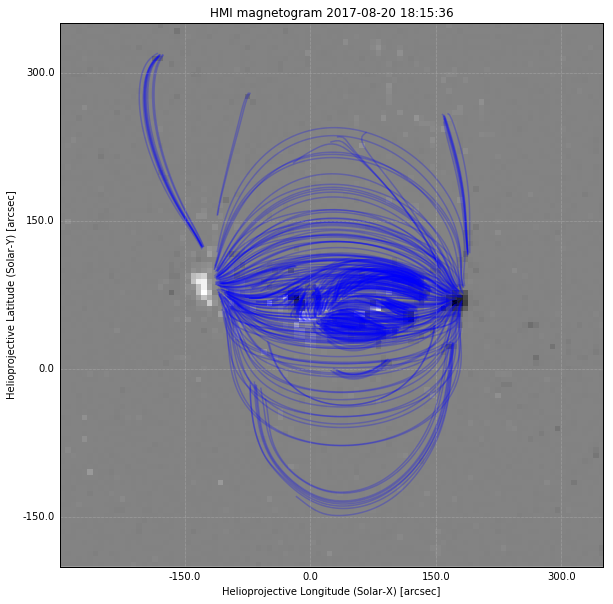

In [12]:
field.peek(alpha=0.25)

In [ ]:
field.extrapolated_3d_field

In [ ]:
field.make_loops()

In [ ]:
field.save(savedir='/Users/willbarnes/Desktop/tmp_save_field')

In [ ]:
# restore
field = synthesizAR.Skeleton.restore('/Users/willbarnes/Desktop/tmp_save_field/')